# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [1]:
# This is only needed if the notebook is run in VSCode
import utils.vscode as vs
vs.DisplayHandle.update = vs.update_patch

In [2]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
import wandb
wandb_api = wandb.Api()



/home/macu/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/macu/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [1]:
import utils.config as cfg
user, project, version, data, config = cfg.get_artifact_config_MVP(True)

ModuleNotFoundError: No module named 'utils'

In [4]:
#hide
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type='encoder_MVP',
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False
)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


In [5]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [6]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

wandb:   1 of 1 files downloaded.  


((40000, 2), (39971, 2, 30))

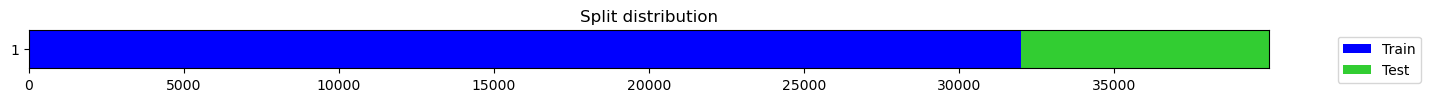

((#31977) [0,1,2,3,4,5,6,7,8,9...],
 (#7994) [31977,31978,31979,31980,31981,31982,31983,31984,31985,31986...])

In [7]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train

if config.analysis_mode == 'online':
    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
    
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
    
splits

Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

In [8]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

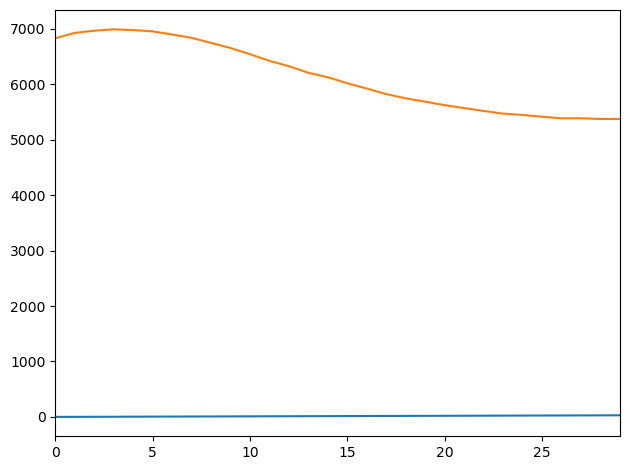

In [9]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]
#X_no_timestamps = X_no_timestamp = X[:, 1:]
dls = get_ts_dls(X, splits=splits, tfms=tfms, 
                 bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

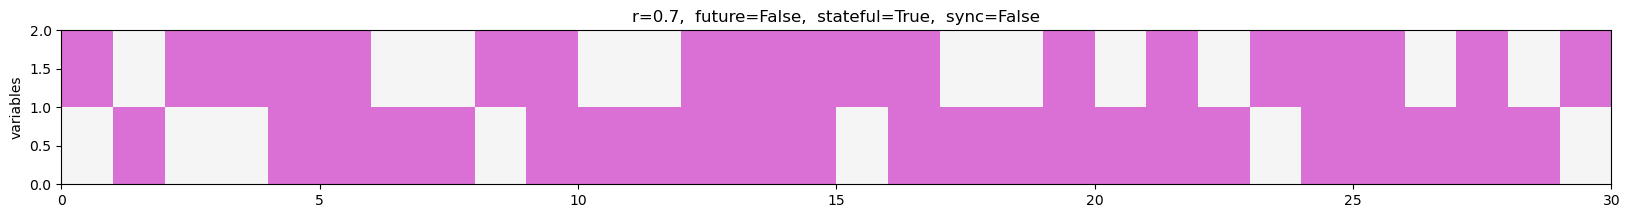

In [10]:
# example mask
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)
    
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

In [ ]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(r = config.r, 
                   window_size=config.mvp_ws, future_mask = config.mask_future, 
                   target_dir='./models', sync = config.mask_sync, stateful = config.mask_stateful,
                   fname=f'encoder_MVP'), y_range=[X.min(), X.max()])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley)

epoch,train_loss,valid_loss,time


In [ ]:
learn.validate()

In [ ]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

In [ ]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: run.log_artifact(ReferenceArtifact(aux_learn, f'mvp', type='learner', metadata=dict(run.config)), 
                                      aliases=config.alias)

In [ ]:
run.finish()